## Objective
Build up to an architecture that can predict digits with 99.4% or higher accuracy (on test set) in 3 stages.

This notebook refers to the **1st of the 3 stages**, where data is prepared for training (using a dataloader) and understanding the data; which might help during augmentatation

---

**Target**
- Download MNIST dataset, both train and test set
- Visualize the images in the dataset
- Explore/understand the characteristics
    - Explore augmentation methods that can be used to improve the model's performance
- Build a DataLoader to load the train and test set (required during training)
- Design a CNN to test the flow
    - Train against the images in the training set
    - Check the test accuracy on the test set

**Results**
- Best Training Accuracy: _99.92_
- Best Test Accuracy: _99.28_
- Model Parameters: _6,379,786_

**Analysis**
- Randomly generating transformation might help the model learn to generalize better. Certain augmentation strategies can be used such as the once below (however the augmentation method suggested isn't used in this step, will be used as required in the later stages)
    - _Rotation_, since some of the digits are not drawn straight
    - _Morphological Erosion_ and _Dilation_ since the thickness of the digits vary. 
- Model uses too many parameters
- The Test/validation Accuracy & Loss fluctuates; which is indicative of model not being able to generalize better (or perform well on test data)
- Also the training accuracy is high where are the test/validation accuracy is comparitively lower, which suggests the model is overfitting on the training set

---

## Imports

In [1]:
# PyTorch, everything from PyTorch can be referred with this
import torch

# Import the neural network model seperately
import torch.nn as nn

# Contains functions that are required such as ReLu (Activation function)
import torch.nn.functional as F 

# Optimizers required to converge using Backpropogation
import torch.optim as optim

# Datasets are used to download and load the data
# used to train and validate
# Transforms can be used to define modifications and/or augmentations methods
# to be applied while passing the data
# Normalization can also be one of the compositions of transforms
import torchvision
from torchvision import datasets, transforms

# Dataset abstract class using which custom dataset classes can be created
# DataLoader to create batches and to shuffle the data
from torch.utils.data import Dataset, DataLoader

# Visualize the images
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid # ImageGrid to form a grid of images

# Utils
import cv2
import numpy as np
import seaborn as sns

In [2]:
# Disable warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

## Download the data

In [3]:
# Define transforms that are to be applied to the images during loading
# Transforms are used to vary the characteristics of the loaded image such as the type 
# (i.e. a numpy n-d array to a torch tensor), normalize the images (by subracting the mean and
# standard deviation) etc.
# Multiple such transforms can be chained together
train_transforms = transforms.Compose ([transforms.ToTensor ()])

In [4]:
# Get the dataset using the defined transforms applied to it
data = datasets.MNIST (root='./data/train/',
                       train=True,
                       download=True,
                       transform=train_transforms)

## Visualize a sample

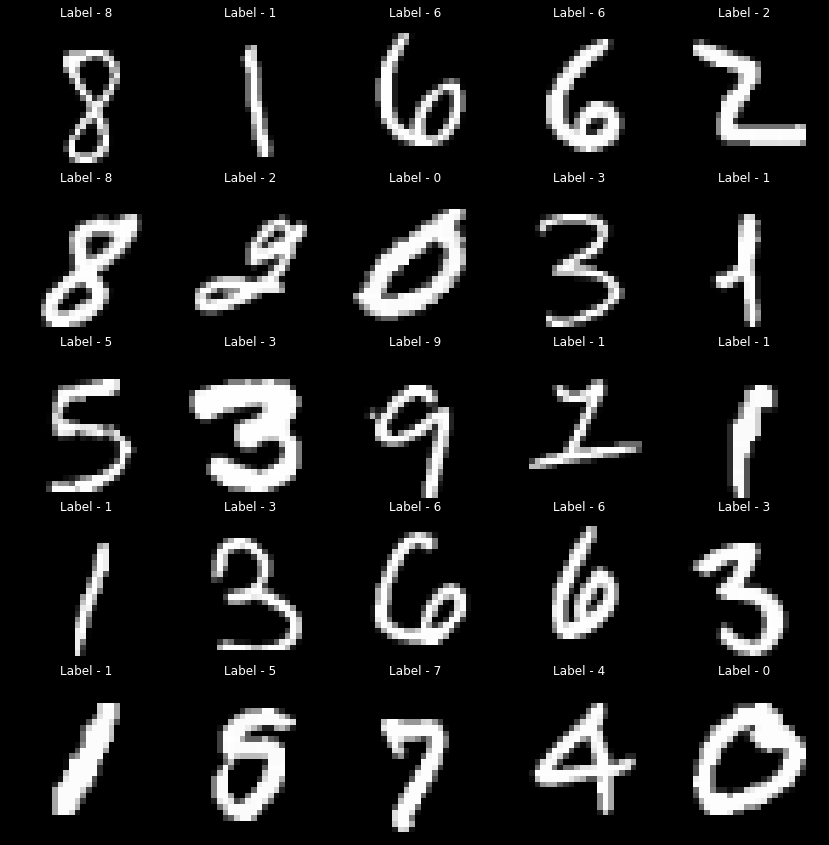

In [5]:
plt.style.use ('dark_background') # Dark mode rocks!!!

# Display random images from the dataset
fig = plt.figure(figsize=(15, 15))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(5, 5),
                 axes_pad=0.1)

for ax, idx in zip (grid, torch.randint (0, len (data), size=(1, 25))[0]):
    # Get the image and label
    img, label = data [idx]

    # Display the image with the label
    ax.imshow (img.view (28, 28), cmap='gray')
    ax.set_title (f'Label - {label}')
    ax.axis ('off');

- We see that some of the digits are rotated slightly and the thickness of digits vary.
    - We can use an augmentitation strategy to based on these observations
    
    - _Rotation_ transformation can be used to train the model to detect digits at different angles (**Do not rotate to much or else the digit might be incorrect (for instance a rotation of 90 degrees would be absurd; 8 would look like inf))**

    - _Dilation and Erosion_ can be used to increase and decrease the thickness of the line(s)
        - This would also remove any artificats/noise in the image

#### Augmentation on samples
Define different transforms (custom transforms too if required) and try the augmentation methods on a few samples
- Custom Transforms can be written (Refer: [PyTorch Documentaiton](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms))

_Erosion_ and _Dilation_ helps to reduce the thickness of the digit and increase it respectively. This could help the model train for different digit widths.
    - Refer: [Blog Post](https://www.cs.auckland.ac.nz/courses/compsci773s1c/lectures/ImageProcessing-html/topic4.htm); [OpenCV Docs](https://docs.opencv.org/master/d9/d61/tutorial_py_morphological_ops.html)

In [6]:
class RandomErosion ():
    ''' Erosion helps to reduce the thickness of the digit 
    Refer to https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms
    on creating custom transformations
    '''

    def __init__ (self, kernel_size=3):
        ''' Initialize the transformation parameters '''

        # Check if the kernel_size is of type of int or tuple
        assert isinstance (kernel_size, (int, tuple)), \
            'Kernel Size (`kernel_size`) should be either be an integer or a tuple'

        # Convert to a tuple in case of int
        kernel_size = (kernel_size, kernel_size) if isinstance (kernel_size, int) else kernel_size

        # Define the kernel of the required size
        self.kernel = np.ones (kernel_size, dtype=np.uint8)

    
    def __call__ (self, sample):
        ''' This method is called when the samples are passed to the transformation object '''
        
        # Get the image and its corresponding label from the sample tuple
        # Check if the sample passed is just an image
        # or tuple containing the labels as well
        if isinstance (sample, tuple):
            image, label = sample
        else:
            image = sample

        # Do this at random
        if not np.random.randint (0, 2):
            # Return the image as is
            return image#, label 

        # Convert the image to a numpy array
        if not isinstance (image, np.ndarray):
            # Resize and convert to numpy array
            image = image.view (28, 28).numpy ()

        # Perform erosion using the defined kernel
        transformed_image = cv2.erode (image, self.kernel)

        # Return the transformed image with the label
        return torch.from_numpy (transformed_image).resize (1, 28, 28)#, label

In [7]:
class RandomDilation ():
    ''' Dilation helps to increase the thickness of the digit 
    Refer to https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms
    on creating custom transformations
    '''

    def __init__ (self, kernel_size=2):
        ''' Initialize the transformation parameters '''

        # Check if the kernel_size is of type of int or tuple
        assert isinstance (kernel_size, (int, tuple)), \
            'Kernel Size (`kernel_size`) should be either be an integer or a tuple'

        # Convert to a tuple in case of int
        kernel_size = (kernel_size, kernel_size) if isinstance (kernel_size, int) else kernel_size

        # Define the kernel of the required size
        self.kernel = np.ones (kernel_size, dtype=np.uint8)


    def __call__ (self, sample):
        ''' This method is called when the samples are passed to the transformation object '''

        # Get the image and its corresponding label from the sample tuple
        # Check if the sample passed is just an image
        # or tuple containing the labels as well
        if isinstance (sample, tuple):
            image, label = sample
        else:
            image = sample

        # Do this at random
        if not np.random.randint (0, 2):
            # Return the image as is
            return image#, label 

        # Convert the image to a numpy array
        if not isinstance (image, np.ndarray):
            # Resize and convert to numpy array
            image = image.view (28, 28).numpy ()

        # Perform erosion using the defined kernel
        transformed_image = cv2.dilate (image, self.kernel)

        # Return the transformed image with the label
        return torch.from_numpy (transformed_image).resize (1, 28, 28)#, label

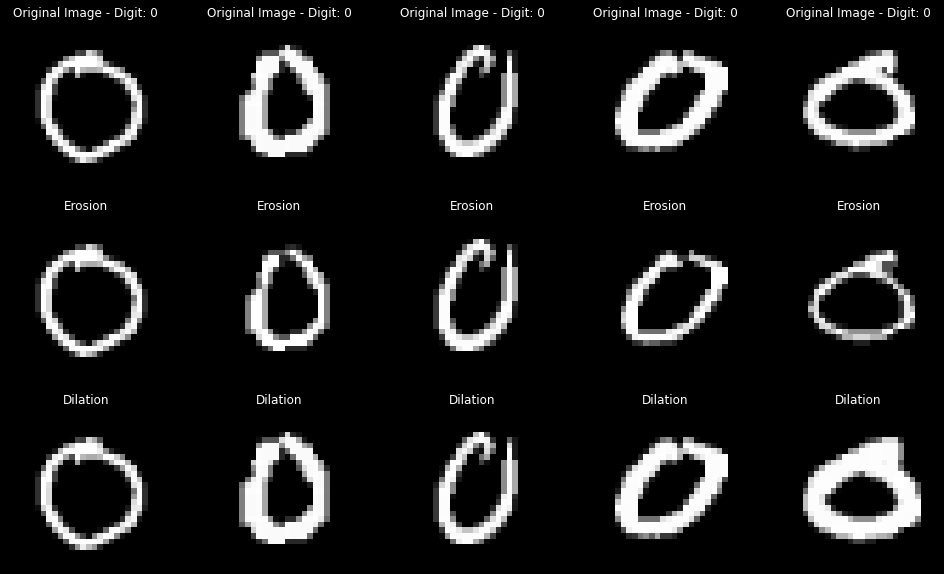

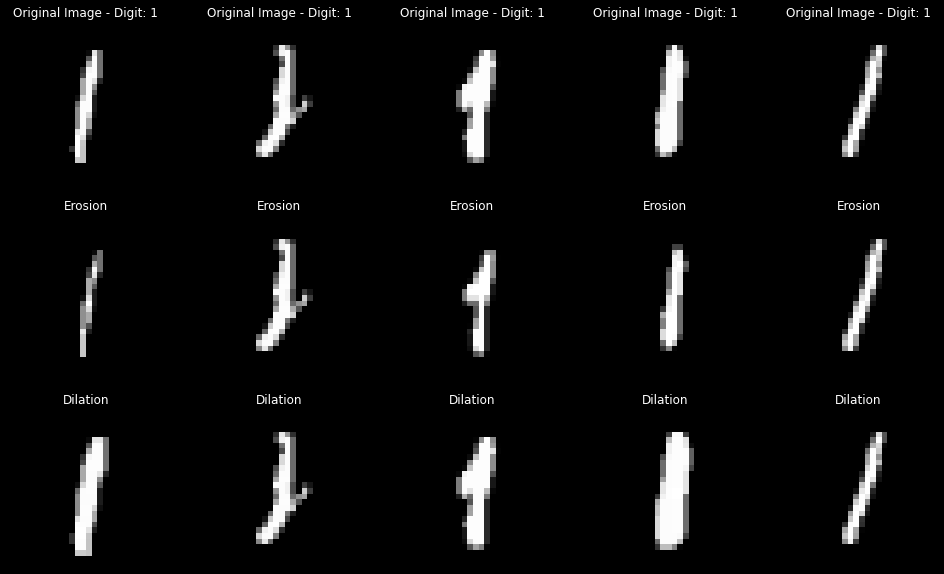

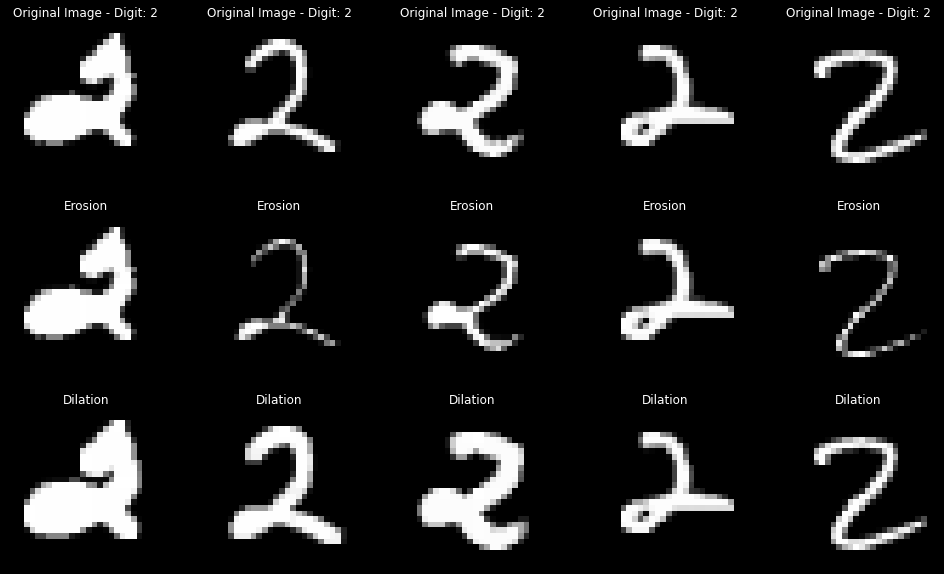

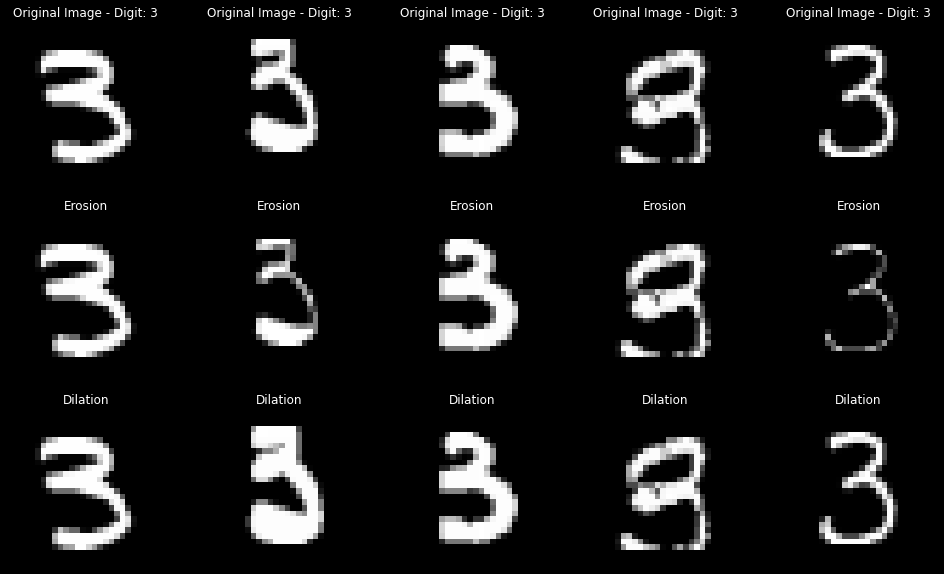

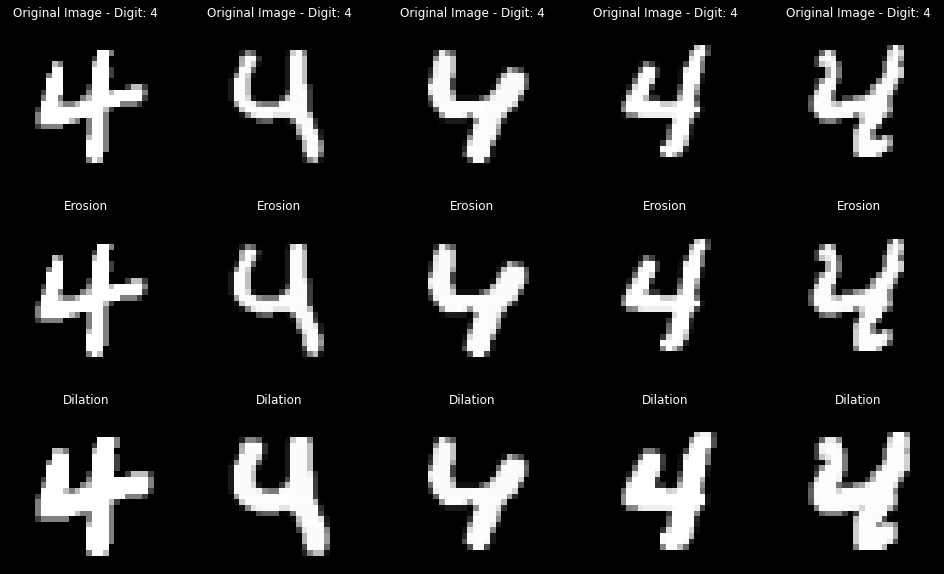

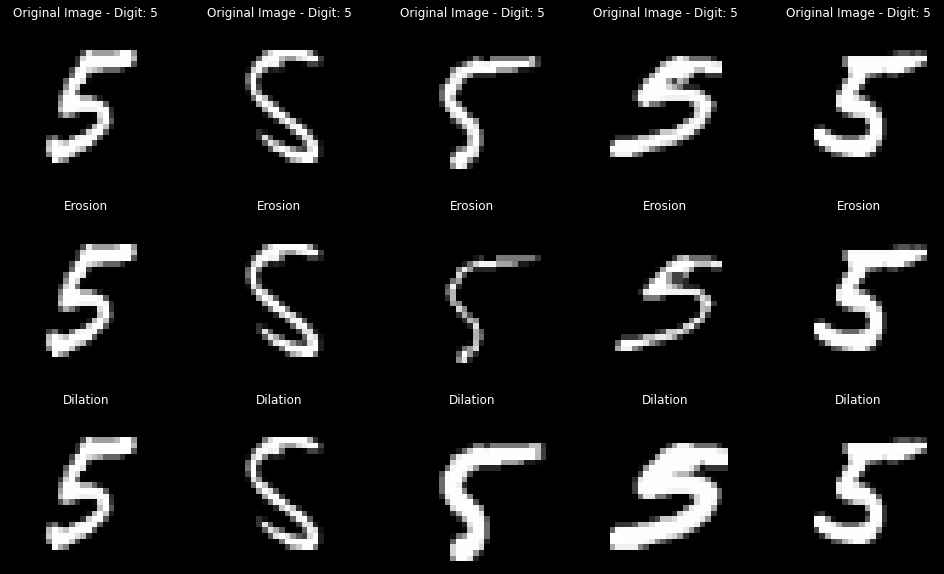

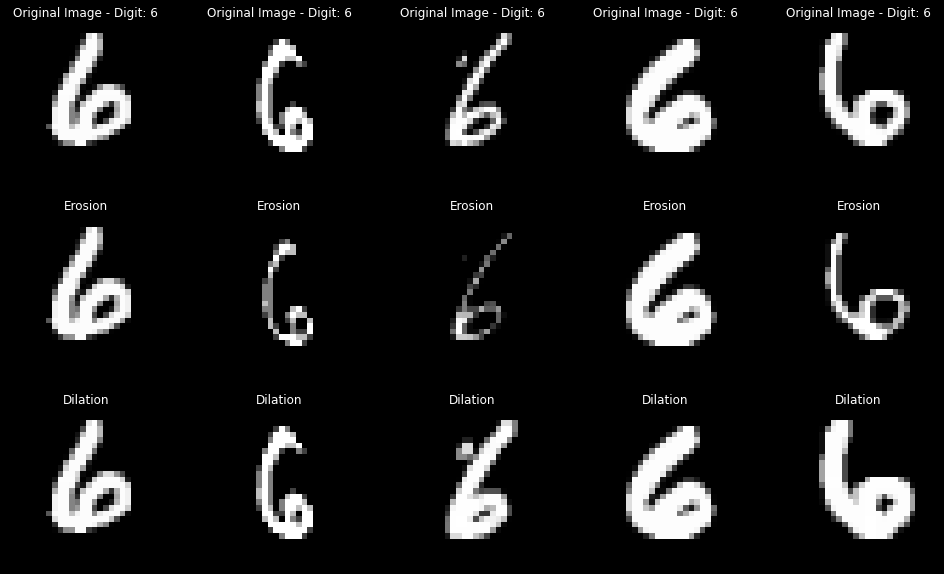

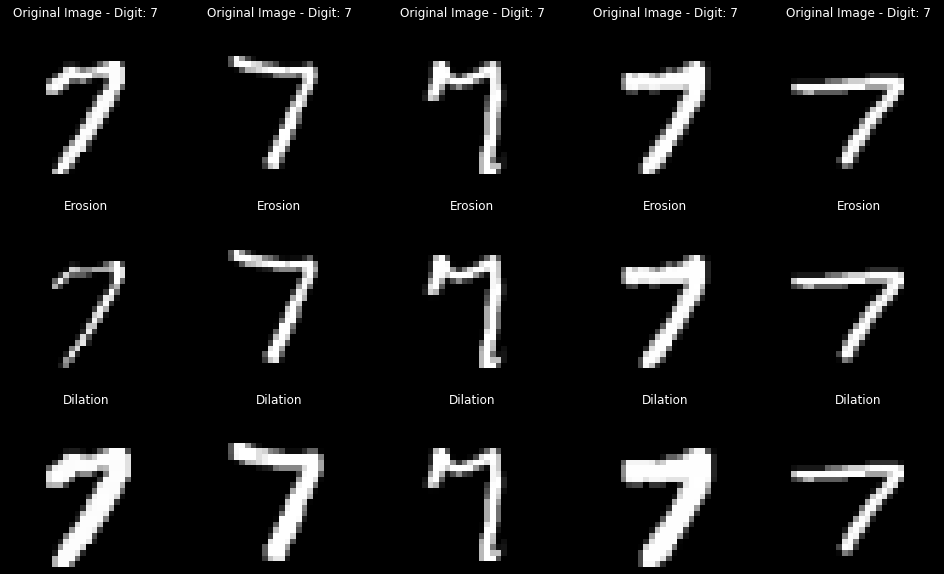

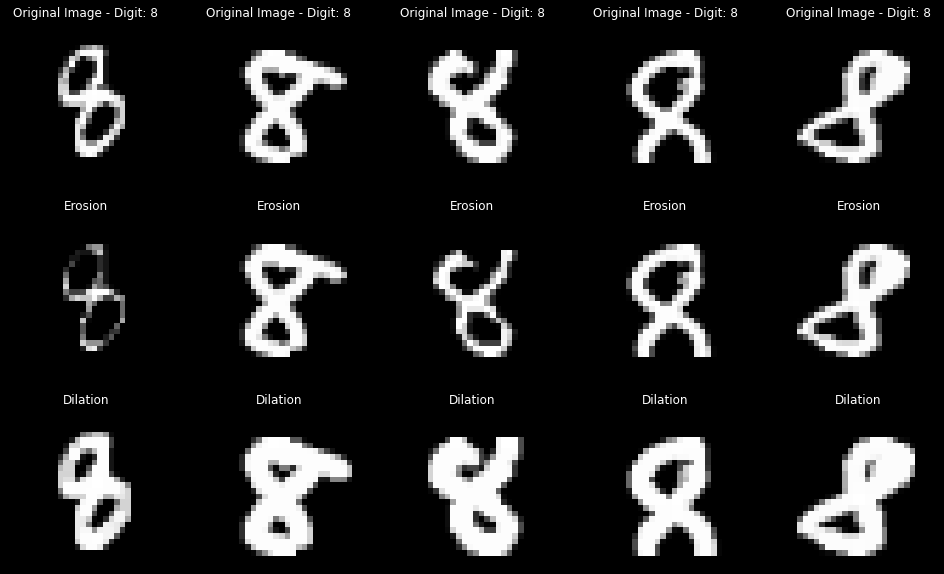

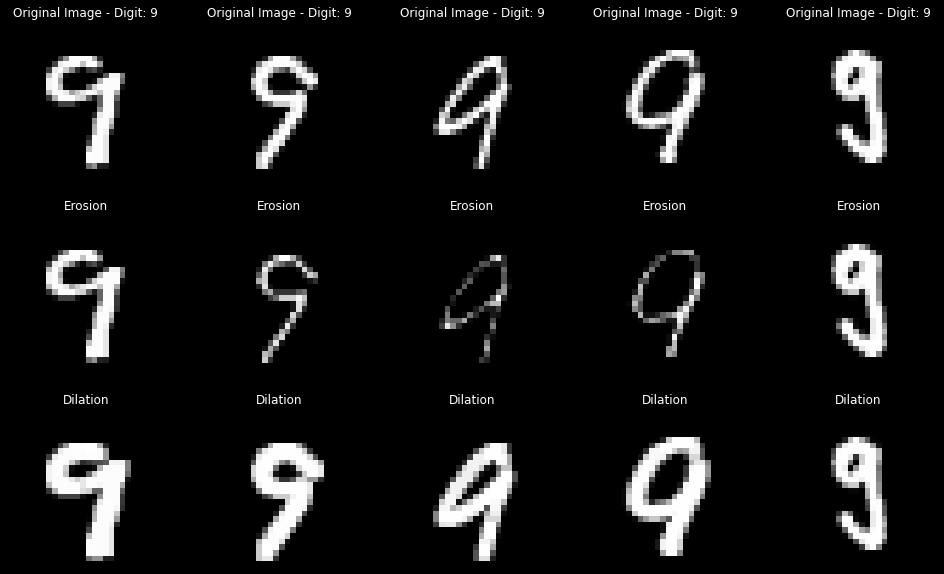

In [8]:
# Erosion & Dilation Transformation
erosion = RandomErosion ((2, 2))
dilation = RandomDilation ((2, 2))

# Get 5 samples for each class
from collections import defaultdict
samples = defaultdict (list)

for idx in torch.randint (0, len (data), size=(1, 100))[0]:
    samples [data [idx] [1]].append (data [idx])

# Iterate through each digit, 5 samples each
for key in sorted (samples):

    # Display random images from the dataset
    fig = plt.figure(figsize=(20, 10))
    grid = ImageGrid(fig, 111, 
                    nrows_ncols=(3, 5),
                    axes_pad=0.5)


    for i, s in enumerate (samples [key]):
        # Display only 5 images 
        if i >= 5: break

        # Get the image and label
        img, label = s

        # Display the original image (before transformation)
        grid[i].imshow (img.view (28, 28), cmap='gray')
        grid[i].set_title (f'Original Image - Digit: {label}')
        grid[i].axis ('off');


        for t_idx, transformation in enumerate ([erosion, dilation], start=1):
            # Perform transformation on the image sample
            t_img = transformation (s)

            # Display the transformed image
            grid[i+5*t_idx].imshow (t_img.view (28, 28), cmap='gray')
            grid[i+5*t_idx].set_title (['Erosion', 'Dilation'] [t_idx-1])
            grid[i+5*t_idx].axis ('off')

## Explore the data
Try to find if optimal receptive field after which MaxPooling can be applied. Ideally for an image of size `400x400`, we would have to go uptill `11x11` to detect most of the required edges/gradients but since the size of the image is `28x28`, the required RF would be around `5x5` or `7x7`.

In [9]:
# For a sample of 1000 random images, compute the number of pixels horizontally and veritically
# to get what the size of the Receptive Field should be before applying MaxPooling

# Define the number of samples
no_of_samples = 1000

# Get `no_of_samples` images and compute RF size required
# To do so, calculate the distance (in pixels) of the lowest point to the 
# highest point, vertically and horizontally

# Store the results
horizontal_distance, vertical_distance = {}, {}

# Iterate through the samples
for idx in torch.randint (0, len (data), size=(1, no_of_samples))[0]:
    # Get the image and label
    img, label = data [idx]

    # Compute the vertical distance
    # Check for values that are not equal to the min (i.e. the background)
    # Since most of the values are the background values, this approach would be faster compute
    horizontal, vertical = np.where (img.reshape (28, 28) != img.min ())

    # Start with horizontal distance
    i, prev_ele = 0, horizontal [0]
    for j, ele in enumerate (horizontal):
        if ele != prev_ele:
            # Compute and store the distance
            try:
                horizontal_distance [label].append (j-i)
            except KeyError:
                horizontal_distance [label] = [j-i]

            # Save the results of the all the digits
            try:
                horizontal_distance ['all'].append (j-i)
            except KeyError:
                horizontal_distance ['all'] = [j-i]

            # Update the index
            i, prev_ele = j, ele

    # Calculate for vertical
    i, prev_ele = 0, vertical [0]
    for j, ele in enumerate (vertical):
        if ele != prev_ele+(j-i):
            # Compute and store the distance
            try:
                vertical_distance [label].append (j-i)
            except KeyError:
                vertical_distance [label] = [j-i]

            # Save the results of the all the digits
            try:
                vertical_distance ['all'].append (j-i)
            except KeyError:
                vertical_distance ['all'] = [j-i]

            # Update the index
            i, prev_ele = j, ele

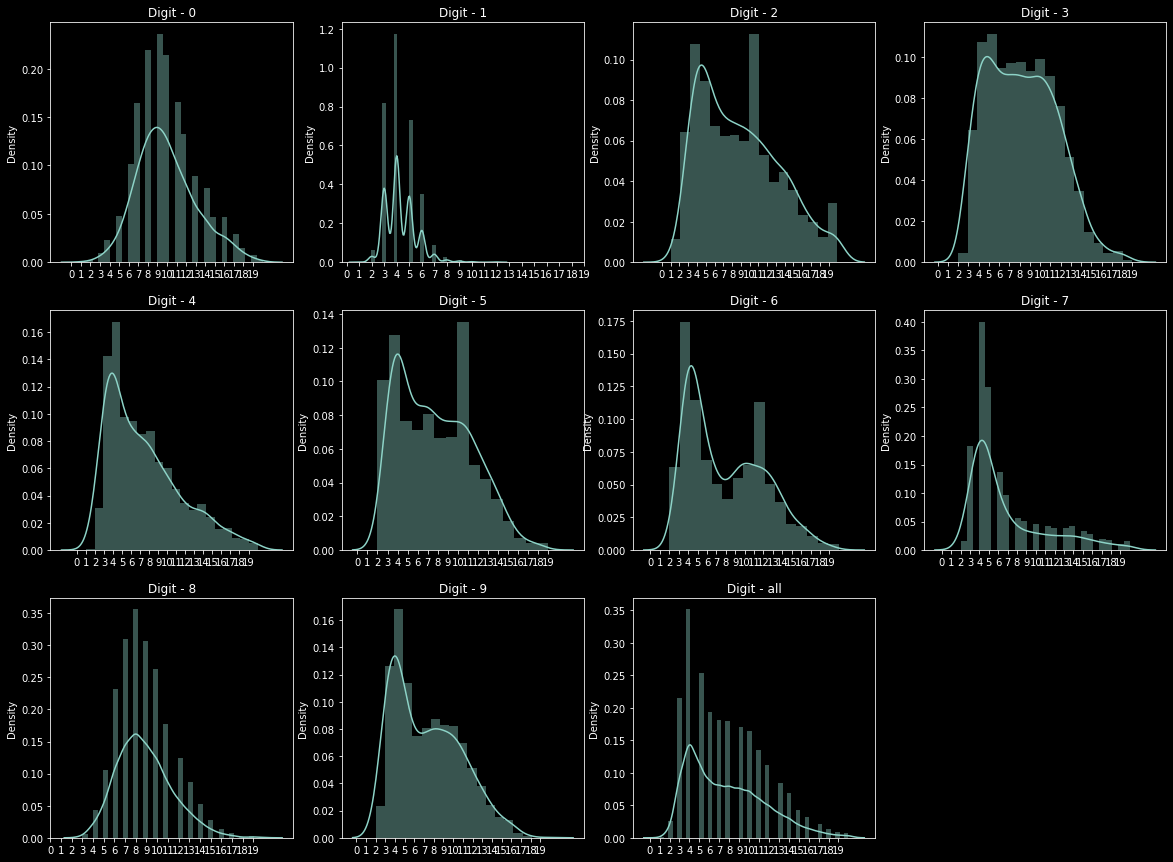

In [10]:
# Iterate through each labels to and display the results
plt.figure(figsize=(20, 15))

for i, k in enumerate (sorted (horizontal_distance.keys (), key=lambda x: str (x)[0]), start=1):
    plt.subplot (3, 4, i)
    sns.distplot (horizontal_distance [k])
    plt.xticks (range (20))
    plt.title (f'Digit - {k}')

**As seen above, most of the edges can be captured with `5x5`/`7x7` (Refer to the peak of the curve). So instead of having more layers, we can limit each block when this RF is reached.**

### Get the global stats of the training set


In [11]:
# Show the no of training samples and the shape of each image
print ('Size of the training set:', data.train_data.cpu ().numpy ().shape)

# Mean across all the training images
print ('Mean of the training set:', torch.mean (data.transform (data.train_data.numpy ())))

# Standard Deviation of the training images
print ('Standard Deviation of the training set:', torch.std (data.transform (data.train_data.numpy ())))

Size of the training set: (60000, 28, 28)
Mean of the training set: tensor(0.1307)
Standard Deviation of the training set: tensor(0.3081)


**Note:** The mean and standard deviation computed is used to normalize both the training and the test set

## Create a custom dataset class
Define a class a that loads and takes the images from MNIST to use as input along with the actual label of the handwritten digit which constitutes the required output

In [12]:
class MNISTDataset (Dataset):
    ''' Extending the Dataset class to provide customized inputs and modified 
    outputs for training '''

    def __init__(self, mode='training', additional_transforms=None):
        ''' Get/Download the data (MNIST) and setup up other configurations
        required to get the data
        
        Parameters:
            mode - Indicates either 'training' or 'validation'
            transforms - A list of additional transformations to be added while training
                            By default Normalized the dataset
        '''

        # Start by initializing the base class
        super().__init__()

        # Save the mode
        # Check if the mode is valid
        assert mode in ['training', 'validation'], \
            '"mode" should be either "training" or "validation"'
        self.mode = mode

        # Seed the random generator to results that are reproduceable
        # Remove during production
        torch.manual_seed(1)

        # Define the transformations
        #   First convert into a tensor and then normalization
        #   Values for normalization where got from 
        #   https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457

        # Define a list of transforms to chain together            
        # Both the train and validation transforms are the same, but might decide 
        # to update with some data augmentation methods for train later
        # so keeping it seperate
        self.transforms = [
            transforms.ToTensor (), 
            transforms.Normalize((0.1307,), (0.3081,))]

        # Get MNIST data
        if self.mode == 'training':        

            # Chain the transforms
            if additional_transforms:
                self.transforms = self.transforms+additional_transforms 
        
            # Download the training set and store it at the root directory
            self.data = datasets.MNIST (
                root='./data/train/',
                train=True,
                download=True,
                transform=transforms.Compose (self.transforms))
            
        elif self.mode == 'validation':

            # Get the validation set
            self.data = datasets.MNIST (
                root='./data/val/',
                train=False,
                download=True,
                transform=transforms.Compose (self.transforms))
        

    def __len__(self):
        ''' Get the total size of the dataset '''
        return len (self.data)


    def __getitem__(self, index):
        ''' Used to get the index-th item from the dataset 
        
        Parameters:
            index - Element value to retrieve from the data
        '''

        # Check if the within the bounds of the data
        assert index < len (self.data), 'The index value is out-of-bound'

        # Index into the data to get the image and the corresponding label
        img, label = self.data [index]

        # Return the training set and the corresponding label
        return img, label

### Load the data
Define the data loaders for train and test with $batch\_size = 128$.

In [13]:
# Seed the random generator used by PyTorch
# so that the results are reproduceable
torch.manual_seed(1)

# Define the batch size to be used
# i.e. the number of images to be used per batch
batch_size = 128

# Set it to use GPU if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Define a dataloader 
# Set the batch_size and shuffle to select
# random images for every batch and epoch

# Parameters to be used while loading the data
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# Additional transformations/augmentations are not added to this
# version, will add that in the next steps
train_loader = DataLoader (
    MNISTDataset (
        mode='training'),
        #additional_transforms=[
        #    RandomErosion ((2, 2)),
        #    RandomDilation ((2, 2))]),
    batch_size=batch_size,
    shuffle=True,
    **kwargs)

test_loader = DataLoader (
    MNISTDataset (mode='validation'),
    batch_size=batch_size,
    shuffle=True,
    **kwargs)

In [14]:
print (f'No. of training batches: {len (train_loader)}\nNo. of test batches: {len (test_loader)}')

No. of training batches: 469
No. of test batches: 79


## Define the network architecture

In [15]:
class Net(nn.Module):
    ''' Define a class initializing the layers constituting the required 
    CNN Architecture and the code for forward pass
    Note: The class extends to the nn.Module, which is a base class for 
    Neural Network modules in PyTorch https://pytorch.org/docs/stable/generated/torch.nn.Module.html
    '''

    def __init__(self):
        ''' Define the layers that constitute the network and
        initialize the base class '''

        # Start by initializing the base class
        super(Net, self).__init__()
    
        # Define the layers that make up the network
        # i.e. the Network Architecture
        # nn.Conv2d - Used to perform 2-dimensional convolution using the defined size of the kernel
        # nn.MaxPool2d - 2d MaxPooling Layer of the defined size

        # MNIST contains images of size 28x28
        # Since the images are padded, the resultant images after convolution
        # would have the same size
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) # Input: 28x28x1; Output: 28x28x32; RF: 3x3
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # Input: 28x28x32; Output: 28x28x64; RF: 5x5
        self.pool1 = nn.MaxPool2d(2, 2) # Input: 28x28x64; Output: 14x14x64; RF: 10x10
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1) # Input: 14x14x64; Output: 14x14x128; RF: 12x12 
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1) # Input: 14x14x128; Output: 14x14x256; RF: 14x14 
        self.pool2 = nn.MaxPool2d(2, 2) # Input: 14x14x256; Output: 7x7x256; RF: 28x28 
        self.conv5 = nn.Conv2d(256, 512, 3) # Input: 7x7x256; Output: 5x5x512; RF: 30x30
        self.conv6 = nn.Conv2d(512, 1024, 3) # Input: 5x5x512; Output: 3x3x1024; RF: 32x32
        self.conv7 = nn.Conv2d(1024, 10, 3) # Input: 3x3x1024; Output: 1x1x10; 

        
    def forward(self, x):
        ''' Define the forward pass
        Each convolution layer is activated using ReLU to add non-linearity
        '''
        # Convolution layer followed by ReLU Activation and then finally a pooling layer
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))

        # Convolution layer followed by ReLU Activation and then finally a pooling layer
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))

        # Conv followed by activation
        x = F.relu(self.conv6(F.relu(self.conv5(x))))

        # The final layer shouldn't be passed through ReLU, but shouldn't be retained
        # as is, before computing the softmax (log)
        #x = F.relu(self.conv7(x))
        x = self.conv7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [16]:
# To display an overview/summary of the network
# Is also useful to validate whether the structure of the network is 
# correct, i.e. the input channels and the output channels and its flow
!pip install torchsummary
from torchsummary import summary

# Set it to use GPU if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Create a model object
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 5, 5]       1,180,160
            Conv2d-8           [-1, 1024, 3, 3]       4,719,616
            Conv2d-9             [-1, 10, 1, 1]          92,170
Total params: 6,379,786
Trainable params: 6,379,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.51
Params size (MB): 24.34
Estimated Total Size (MB): 25.85
-------------------------------------

## Train and Validate

In [17]:
# TQDM is just awesome... provides a progress status bar as the training 
# (or any operation) proceeds
from tqdm import tqdm


def train(model, device, train_loader, optimizer, epoch):
    ''' Define the training steps '''

    # Set the model to training mode
    model.train()
    
    # Initialize the counters
    correct = 0
    processed = 0

    # Initialize the progress bar
    pbar = tqdm(train_loader)

    # Start iterating through the training data
    for batch_idx, (data, target) in enumerate(pbar):
        # Start by converting the data to the required type 
        # (PyTorch Cuda Tensor while using GPU)
        data, target = data.to(device), target.to(device)

        # Discard/reset the gradients from the last iteration
        optimizer.zero_grad()

        # Get the predictions for the given data
        output = model(data)

        # Compute the negative loss likelihood of the predictions vs the actuals
        # and propogate the loss backwards (back propogation)
        loss = F.nll_loss(output, target)
        loss.backward()

        # Use the optimizer to take a step in the -ve of the gradient direction
        # by the amount equal to the gradient magnitude times the learning rate 
        optimizer.step()
        
        # Get the index of the prediction
        # i.e. the output is one-hot encoded, so get the argument with the max
        # log probability
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

        # Get a count of the correct preditcions
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        # Update the no of records processed
        processed += len (data)

        # Update the progress bar
        pbar.set_description(
            desc=f'Loss={loss.item():.4f}; '+\
                 f'Accuracy={correct*100/processed:.2f}; '+\
                 f'Learning Rate={optimizer.param_groups[0]["lr"]:.4f}')
        
        # Store the training accuracy & loss
        training_accuracy.append (correct*100/processed)
        training_losses.append (loss)


def test(model, device, test_loader):
    ''' Validate the trained model on a hold-out set '''

    # Set the model to evalution mode
    model.eval()
    
    # Initialize the losses
    # and the no of correct predictions to 0
    test_loss = 0
    correct = 0

    # Disable the gradient computations
    # While evaulating only forward pass is used and the backward pass
    # along with the gradient (likewise the gradient update) isn't required
    with torch.no_grad():
        # Iterate over the test/validation set
        for data, target in test_loader:
            # Converting the data to the required type 
            # (PyTorch Cuda Tensor while using GPU)
            data, target = data.to(device), target.to(device)

            # Get the predictions
            output = model(data)

            # Compute the loss against the target
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            # Get the index of the prediction
            # i.e. the output is one-hot encoded, so get the argument with the max
            # log probability
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

            # Get a count of the correct preditcions
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Compute the final loss on the test/validation data
    test_loss /= len(test_loader.dataset)

    # Display the results
    print('\nTest set: Loss={:.4f}; Accuracy={}/{} ({:.2f}%)\n\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # Store the training accuracy & loss
    test_accuracy.append (correct*100/len(test_loader.dataset))
    test_losses.append (test_loss)

In [18]:
# Initialize the model instance
model = Net().to(device)

# Define an optimizer to use to perform gradient descent
# Various optimizers are suitable for different usecase, which help
# reach the global optimal (i.e. a model with least errors/loss) quickly
# In this case, Stochastic Gradient Descent (SGD) is used with momentum of 0.9
# and the learning rate (alpha) set to 0.01 
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Train the model for n epochs
epochs = 14

# Store the training accuracy and losses
training_accuracy = []
training_losses = []

# Store the test accuracy and losses
test_accuracy = []
test_losses = []

for epoch in range(0, epochs):
    print (f'Iteration {epoch+1}')
    # Initiate training phase
    train(model, device, train_loader, optimizer, epoch)

    # Validate the results on the test/validation set
    test(model, device, test_loader)

print (f'Best Model had a Training Accuracy of {np.max (training_accuracy):.2f}', 
        f'& a Test Accuracy of {np.max (test_accuracy):.2f}')

  0%|          | 0/469 [00:00<?, ?it/s]

Iteration 1


Loss=0.0134; Accuracy=89.33; Learning Rate=0.0100: 100%|██████████| 469/469 [00:18<00:00, 25.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0563; Accuracy=9813/10000 (98.13%)


Iteration 2


Loss=0.1042; Accuracy=98.40; Learning Rate=0.0100: 100%|██████████| 469/469 [00:18<00:00, 24.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0370; Accuracy=9893/10000 (98.93%)


Iteration 3


Loss=0.0210; Accuracy=98.94; Learning Rate=0.0100: 100%|██████████| 469/469 [00:19<00:00, 24.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0314; Accuracy=9898/10000 (98.98%)


Iteration 4


Loss=0.0280; Accuracy=99.23; Learning Rate=0.0100: 100%|██████████| 469/469 [00:19<00:00, 24.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0296; Accuracy=9909/10000 (99.09%)


Iteration 5


Loss=0.0447; Accuracy=99.38; Learning Rate=0.0100: 100%|██████████| 469/469 [00:19<00:00, 24.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0305; Accuracy=9898/10000 (98.98%)


Iteration 6


Loss=0.0054; Accuracy=99.54; Learning Rate=0.0100: 100%|██████████| 469/469 [00:18<00:00, 24.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0245; Accuracy=9911/10000 (99.11%)


Iteration 7


Loss=0.0069; Accuracy=99.66; Learning Rate=0.0100: 100%|██████████| 469/469 [00:19<00:00, 24.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0295; Accuracy=9915/10000 (99.15%)


Iteration 8


Loss=0.0499; Accuracy=99.76; Learning Rate=0.0100: 100%|██████████| 469/469 [00:19<00:00, 24.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0303; Accuracy=9903/10000 (99.03%)


Iteration 9


Loss=0.0008; Accuracy=99.83; Learning Rate=0.0100: 100%|██████████| 469/469 [00:19<00:00, 24.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0288; Accuracy=9919/10000 (99.19%)


Iteration 10


Loss=0.0077; Accuracy=99.82; Learning Rate=0.0100: 100%|██████████| 469/469 [00:19<00:00, 24.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0271; Accuracy=9927/10000 (99.27%)


Iteration 11


Loss=0.0009; Accuracy=99.90; Learning Rate=0.0100: 100%|██████████| 469/469 [00:19<00:00, 24.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0331; Accuracy=9906/10000 (99.06%)


Iteration 12


Loss=0.0039; Accuracy=99.83; Learning Rate=0.0100: 100%|██████████| 469/469 [00:19<00:00, 24.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0341; Accuracy=9913/10000 (99.13%)


Iteration 13


Loss=0.0008; Accuracy=99.91; Learning Rate=0.0100: 100%|██████████| 469/469 [00:19<00:00, 24.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0277; Accuracy=9928/10000 (99.28%)


Iteration 14


Loss=0.0002; Accuracy=99.92; Learning Rate=0.0100: 100%|██████████| 469/469 [00:19<00:00, 24.60it/s]



Test set: Loss=0.0336; Accuracy=9917/10000 (99.17%)


Best Model had a Training Accuracy of 100.00 & a Test Accuracy of 99.28


### Plot the accuracy and loss

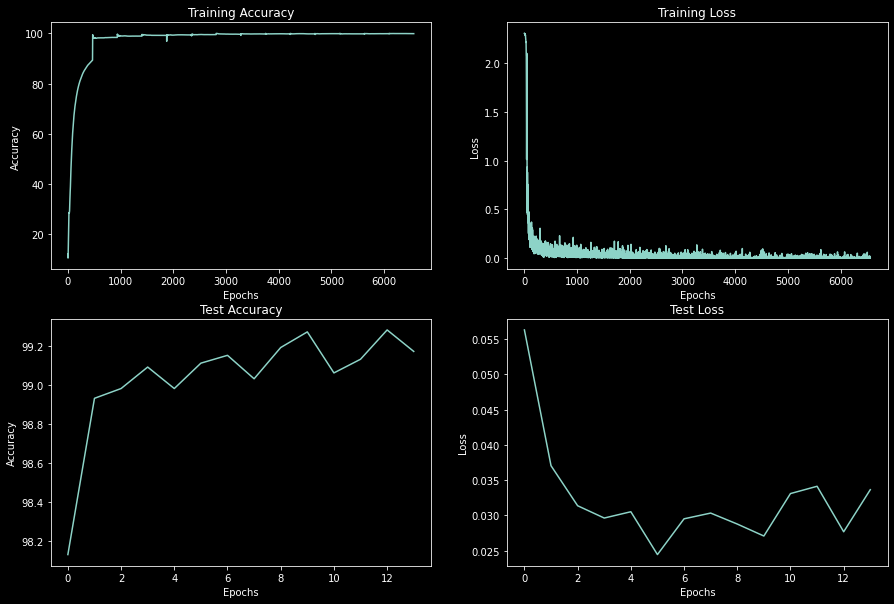

In [19]:
# Define the size of the figure
plt.figure (figsize=(15, 10))

# Plot the Training Accuracy
plt.subplot (221)
plt.plot (training_accuracy)
plt.title ('Training Accuracy')
plt.ylabel ('Accuracy'); plt.xlabel ('Epochs');

# Losses during training
plt.subplot (222)
plt.plot (training_losses)
plt.title ('Training Loss')
plt.ylabel ('Loss'); plt.xlabel ('Epochs');

# Test Accuracy at each epoch
plt.subplot (223)
plt.plot (test_accuracy)
plt.title ('Test Accuracy')
plt.ylabel ('Accuracy'); plt.xlabel ('Epochs');

# Test Losses at each epoch
plt.subplot (224)
plt.plot (test_losses)
plt.title ('Test Loss')
plt.ylabel ('Loss'); plt.xlabel ('Epochs');

- The Test/validation Accuracy & Loss fluctuates; which is indicative of model not being able to generalize better (or perform well on test data)
- Also the training accuracy is high where are the test/validation accuracy is comparitively lower, which suggests the model is overfitting on the training set